# Malaria Convolutional Neural Network
Using deep learning to improve a model that can understand when is parasitized or uninfected by a cell image

___
Using the Tensorflow for models and Tensorflow Datasets to get a cell images of malaria.

[Malaria Dataset](https://www.tensorflow.org/datasets/catalog/malaria)

### Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from matplotlib import pyplot

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


___
### This notebook has the follows steps:
- Load data
- Understand data
- Prepare data
- Build a models
- Train models
- Validate models
- Improve the best model
    * Build model
    * Train model
    * Validate model

## Load data

In [2]:
dataset = tfds.builder('malaria')

In [3]:
dataset.download_and_prepare()

I define the dataset split with 70% of all data is for train, 10% is used for validate the train and 20% is used for data test.

In [4]:
dataset_train, train_info = tfds.load('malaria', split='train[0%:70%]', with_info=True)
dataset_validate, validate_info = tfds.load('malaria', split='train[70%:80%]', with_info=True)
dataset_test, test_info = tfds.load('malaria', split='train[80%:99%]', with_info=True)

## Understand data

In [5]:
dataset.info

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

In [6]:
train_size = len(list(dataset_train.as_numpy_iterator()))
validate_size = len(list(dataset_validate.as_numpy_iterator()))
test_size = len(list(dataset_test.as_numpy_iterator()))

In [7]:
print(f'The train dataset has {train_size} total of examples')
print(f'The validate dataset has {validate_size} total of examples')
print(f'The test dataset has {test_size} total of examples')

The train dataset has 19291 total of examples
The validate dataset has 2755 total of examples
The test dataset has 5236 total of examples


In [8]:
train_uninfected_size = len(list(dataset_train.filter(lambda x: x['label'] == 1).as_numpy_iterator()))
validate_uninfected_size = len(list(dataset_validate.filter(lambda x: x['label'] == 1).as_numpy_iterator()))
test_uninfected_size = len(list(dataset_test.filter(lambda x: x['label'] == 1).as_numpy_iterator()))

In [9]:
print(f'Into train has {train_uninfected_size} of uninfected examples and {train_size - train_uninfected_size} of parasitized samples.')
print(f'Into validate has {validate_uninfected_size} of uninfected examples and {validate_size - validate_uninfected_size} of parasitized samples.')
print(f'Into test has {test_uninfected_size} of uninfected examples and {test_size - test_uninfected_size} of parasitized samples.')

Into train has 9650 of uninfected examples and 9641 of parasitized samples.
Into validate has 1397 of uninfected examples and 1358 of parasitized samples.
Into test has 2595 of uninfected examples and 2641 of parasitized samples.


#### Item from train split

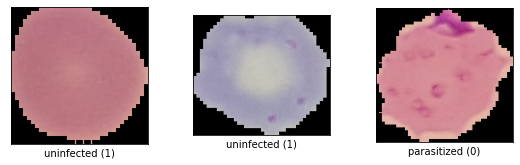

In [11]:
train_figure = tfds.show_examples(train_info, dataset_train, rows=1, cols=3)

#### item from validation split

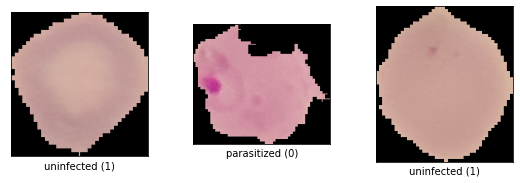

In [12]:
validate_figure = tfds.show_examples(validate_info, dataset_validate, rows=1, cols=3)

#### Item from test split

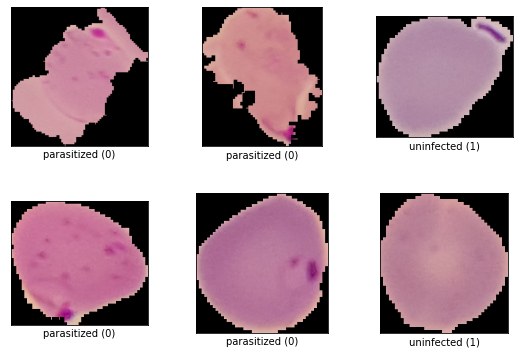

In [13]:
test_figure = tfds.show_examples(test_info, dataset_test, rows=2, cols=3)

## Prepare data

In [10]:
batch_size = 32
shuffle_size = 1024

image_height = 128
image_width = 128

epochs = 16
learning_rate = 0.00001
n_classes = 2

In [11]:
def resize_image(sample):
    resize = tf.image.resize_with_pad(sample['image'], target_height=image_height, target_width=image_width)
    resize / 255.0
    return resize, tf.one_hot(sample['label'], n_classes)

In [12]:
train = dataset_train.map(resize_image).repeat().shuffle(shuffle_size).batch(batch_size)
validate = dataset_validate.map(resize_image).repeat().shuffle(shuffle_size)

test = dataset_test.map(resize_image).shuffle(shuffle_size)

In [13]:
train

<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None, 2)), types: (tf.float32, tf.float32)>

## Build Models

In [14]:
class Model_One(tf.keras.Model):
    def __init__(self):
        super(Model_One, self).__init__()
        self.layer_conv_1 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='SAME', activation='relu')
        self.layer_conv_2 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='SAME', activation='relu')
        self.layer_conv_3 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='SAME', activation='relu')
        
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), 
                                                  strides=(2, 2), 
                                                  padding='SAME')
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(rate=0.15)
        
        self.layer_dense_1 = tf.keras.layers.Dense(128, activation='relu')
        self.layer_dense_2 = tf.keras.layers.Dense(128, activation='relu')
        self.classifier = tf.keras.layers.Dense(2, activation='relu')
    
    def call(self, inputs):
        x = self.layer_conv_1(inputs)
        x = self.max_pool(x)
        
        x = self.layer_conv_2(x)
        x = self.max_pool(x)
        
        x = self.layer_conv_3(x)
        x = self.max_pool(x)
        
        x = self.dropout(x)
        
        x_flatten = self.flatten(x)
        
        x_dense = self.layer_dense_1(x_flatten)
        x_dense = self.dropout(x_dense)
        
        x_dense = self.layer_dense_2(x_dense)
        x_dense = self.dropout(x_dense)
        
        return self.classifier(x_dense)

In [15]:
model = Model_One()

### Train Model

In [16]:
loss = tf.keras.losses.BinaryCrossentropy()
accuracy = tf.keras.metrics.Accuracy()

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
losses = []
accuracies = []

with tf.GradientTape(persistent=True) as tape:
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs}')
        for step, (images, targets) in enumerate(train):
            results = model(images)
            loss_value = loss(results, targets)
            accuracy_value = accuracy(results, targets)
            
            gradient = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(gradient, model.trainable_weights))
            
            if step % 100 == 0:
                losses.append(loss_value)
                accuracies.append(accuracy_value)
                print(f'The batch numer {step}/{int(train_size/batch_size)}, epoch {epoch}/{epochs}, with loss {loss_value} and accuracy is {accuracy_value}%')
                
        for images, targets in dataset_validate:
            results = model(images)
            loss_value = loss(results, targets)
            accuracy_value = accuracy(results, targets)
            
            print(f'The validation data loss is {loss_value} and accuraccy {"{0:.2f}".format(accuracy_value)}%')

Epoch 0/16


The batch numer 0/602, epoch 0/16, with loss 13.522961616516113 and accuracy is 0.0%
The batch numer 100/602, epoch 0/16, with loss 2.2567577362060547 and accuracy is 0.0%
The batch numer 200/602, epoch 0/16, with loss -8.402276992797852 and accuracy is 0.00015470296784769744%
